In [1]:
import numpy as np
import pandas as pd
from detecta import detect_peaks, detect_onset
import spm1d
from tnorma import tnorma
from glob import glob
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import csv
import pingouin as pg
import seaborn as sns


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

def lowpass_filter(data, cut_freq, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cut_freq / nyq
    b, a = butter(order, normal_cutoff, btype= 'low')
    filtered_data = filtfilt(b, a, data)
    return filtered_data


/Users/yongseok/opt/anaconda3/envs/ML/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
FST_CMJ_DIR = [i.replace('\\','/') for i in glob('Data/**/1차/*csv') if 'Countermovement' in i]
SCD_CMJ_DIR = [i.replace('\\','/') for i in glob('Data/**/2차/*csv') if 'Countermovement' in i]

FST_LAND_DIR = [i.replace('\\','/') for i in glob('Data/**/1차/*csv') if 'Land and Hold' in i]
SCD_LAND_DIR = [i.replace('\\','/') for i in glob('Data/**/2차/*csv') if 'Land and Hold' in i]

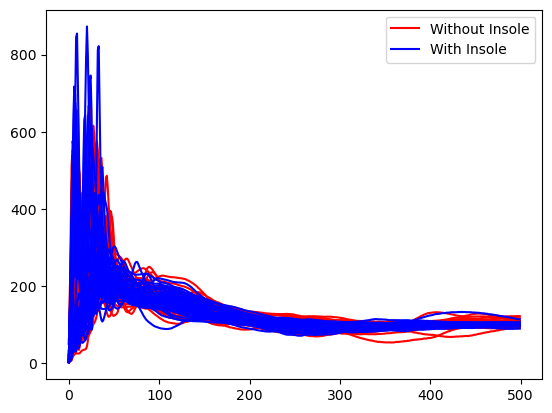

In [3]:
CMJLAND = {
    '1차' : {},
    '2차' : {}
}
CMJJUMP = {
    '1차' : {},
    '2차' : {}
}
CMJLAND_PEAK = {
    '1차' : [],
    '2차' : []
}
CMJJUMP_PEAK = {
    '1차' : [],
    '2차' : []
}
JUMPTIME ={
    '1차' : [],
    '2차' : []
}
plt.style.use("default")
for DIR in [FST_CMJ_DIR, SCD_CMJ_DIR]:
    for file_dir in DIR:
        f = open(file_dir,'r')
        rdr = csv.reader(f)

        for line in rdr:
            if 'Weight' in line:
                weight = line[1]

        _, name, order, trial = file_dir.split('/')
        trial = trial.split('-')[-1].replace('.csv','')   
        name_trial = name + '_' + trial

        df = pd.read_csv(file_dir,sep=',',skiprows=8)
        df['Force'] = df['Left'] + df['Right']
        df['jump'] = df['Force'] - df['Force'][0]
        
        plot = False
        landing_time = detect_onset(df['Force'],threshold=10,show=plot)[-1][0]
        jumping_time = detect_onset(df['Force'],threshold=10,show=plot)[0][-1]
        cm_time = detect_onset(df['jump'], threshold=0,n_below=100,show=plot)[0][-1]
        jump_time = (landing_time - jumping_time)/500
        df['jump_time'] = jump_time
        df['weight'] = weight
        cmjland = df.iloc[landing_time:landing_time+500].reset_index(drop=True)[['Power','Impulse','Force','jump_time','weight']]
        cmjjump = df.iloc[cm_time:jumping_time+1].reset_index(drop=True)[['Power','Impulse','Force','jump_time','weight']]
        
        max_frame = np.where(cmjjump['Force'] == cmjjump['Force'].max())[0][0]
        min_frame = np.where(cmjjump['Force'] == cmjjump.iloc[:max_frame]['Force'].min())[0][0]
        
        cmjjump = cmjjump.iloc[min_frame:]
        filt_cols = ['Power','Impulse','Force']
        # for c in filt_cols:
        #     cmjland[c] = lowpass_filter(cmjland[c], 60, 500, 4)
        
        cmjland[filt_cols] = 100 * (cmjland[filt_cols]/9.81) / float(weight)
        cmjjump[filt_cols] = 100 * (cmjjump[filt_cols]/9.81) / float(weight)
        
        tn, a, b = tnorma(cmjjump[filt_cols], step=-300)
        cmjjump = pd.DataFrame(tn, columns=filt_cols)
        
        if order == '1차':
            CMJLAND['1차'][name_trial] = cmjland
            CMJJUMP['1차'][name_trial] = cmjjump
            CMJLAND_PEAK['1차'].append(cmjland.max().tolist()[:-2])
            CMJJUMP_PEAK['1차'].append(cmjjump.max().tolist())
            JUMPTIME['1차'].append(jump_time)
            color = 'r'
            lb = 'Without Insole'
        elif order == '2차':
            CMJLAND['2차'][name_trial] = cmjland
            CMJJUMP['2차'][name_trial] = cmjjump 
            CMJLAND_PEAK['2차'].append(cmjland.max().tolist()[:-2])
            CMJJUMP_PEAK['2차'].append(cmjjump.max().tolist())    
            JUMPTIME['2차'].append(jump_time)        
            color = 'b'
            lb = 'With Insole'
        plt.plot(cmjland['Force'],color=color, label = lb)

# 현재 축에 있는 범례 핸들과 레이블을 가져옵니다.
handles, labels = plt.gca().get_legend_handles_labels()

# 중복된 레이블을 제거합니다.
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)

# 중복 없는 범례를 생성합니다.
plt.legend(newHandles, newLabels)

plt.show()

CMJLAND_PEAK['1차'] = pd.DataFrame(CMJLAND_PEAK['1차'], columns = ['Power','Impulse','Force'])
CMJJUMP_PEAK['1차'] = pd.DataFrame(CMJJUMP_PEAK['1차'], columns = ['Power','Impulse','Force'])
CMJLAND_PEAK['2차'] = pd.DataFrame(CMJLAND_PEAK['2차'], columns = ['Power','Impulse','Force'])
CMJJUMP_PEAK['2차'] = pd.DataFrame(CMJJUMP_PEAK['2차'], columns = ['Power','Impulse','Force'])

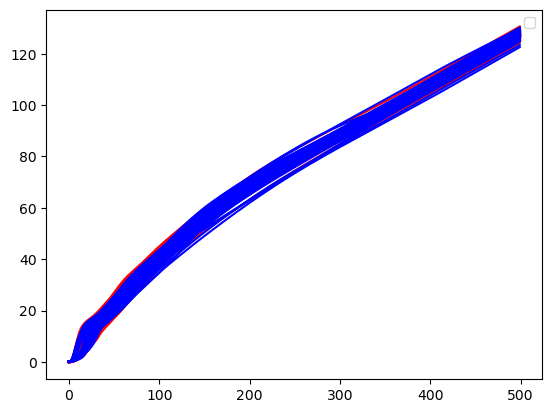

In [4]:
from scipy.integrate import cumtrapz
LAND = {
    '1차' : {},
    '2차' : {}
}
LAND_PEAK = {
    '1차' : [],
    '2차' : []
}
plt.style.use("default")
for DIR in [FST_LAND_DIR, SCD_LAND_DIR]:
    for file_dir in DIR:
        f = open(file_dir,'r')
        rdr = csv.reader(f)

        for line in rdr:
            if 'Weight' in line:
                weight = line[1]
        _, name, order, trial = file_dir.split('/')
        trial = trial.split('-')[-1].replace('.csv','')   
        name_trial = name + '_' + trial

        df = pd.read_csv(file_dir,sep=',',skiprows=8)
        df['Force'] = df['Left'] + df['Right']
        df['weight'] = weight
        dt = 1/500
        impulse = cumtrapz(df['Force'],dx = dt, initial=0)
        df['Impulse'] = impulse
        landing_time = detect_onset(df['Force'],threshold=10,show=plot)[-1][0]
        land = df.iloc[landing_time:landing_time+500].reset_index(drop=True)[['Force','Impulse','weight']]
        
        # land['total'] = lowpass_filter(land['total'], 60, 500, 4)
        land['Force'] = 100 * (land['Force'] / 9.81) / float(weight)
        land['Impulse'] = 100 * (land['Impulse'] / 9.81) / float(weight)
        
        if order == '1차':
            LAND['1차'][name_trial] = land
            LAND_PEAK['1차'].append(land.max().tolist()[0])
            color = 'r'
        elif order == '2차':
            LAND['2차'][name_trial] = land   
            LAND_PEAK['2차'].append(land.max().tolist()[0])
            color = 'b'
        plt.plot(land['Impulse'],color=color)

# 현재 축에 있는 범례 핸들과 레이블을 가져옵니다.
handles, labels = plt.gca().get_legend_handles_labels()

# 중복된 레이블을 제거합니다.
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)

# 중복 없는 범례를 생성합니다.
plt.legend(newHandles, newLabels)

plt.show()

# Pairde T test : SPM

### CMJ Jumping

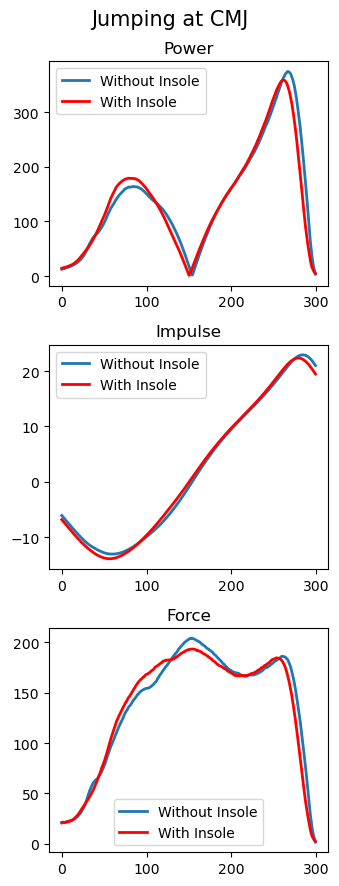

In [29]:
spm = {
    
}
# fig, ax = plt.subplots(3,2, figsize=(7,9))
fig, ax = plt.subplots(3,1, figsize=(3.5,9))
for i,c in enumerate(['Power','Impulse','Force']):
    f_cmj = pd.DataFrame()
    s_cmj = pd.DataFrame()
    for order in ['1차', '2차']:
        for trial in CMJJUMP[order]:        
            df = pd.Series(CMJJUMP[order][trial][c], name=trial)

            if order == '1차':
                f_cmj = pd.concat([f_cmj, df], axis=1)
            if order == '2차':
                s_cmj = pd.concat([s_cmj, df], axis=1)

    Y0 = f_cmj.values.T
    Y1 = s_cmj.values.T
    ax[i].plot(Y0[0,:],lw=2,label='Without Insole')
    ax[i].plot(Y1[0,:], c='r', lw=2, label='With Insole')
    ax[i].legend()
    ax[i].set_title(c)
    if c == 'Power':
        ymax = max(Y0[0,:])
        xpos = np.argmax(Y0[0,:])
        xmax = Y0[0,:][xpos]

        # 최대값에 화살표와 주석을 추가합니다.
        ax[i].annotate('Max: {:.2f}'.format(ymax), xy=(xmax, ymax), xytext=(xmax, ymax+50),
                    arrowprops=dict(facecolor='black', shrink=0.05))
    # t  = spm1d.stats.ttest2(Y0, Y1, equal_var=True)
    # ti = t.inference(alpha=0.05, two_tailed=True, interp=True)
    
    # spm1d.plot.plot_mean_sd(Y0, ax=ax[i,0],lw=2,label='Without Insole')
    # spm1d.plot.plot_mean_sd(Y1, linecolor='r', lw=2,facecolor='r', ax=ax[i,0], label='With Insole')
    # t  = spm1d.stats.ttest_paired(Y0, Y1)
    # ti = t.inference(alpha=0.05, two_tailed=True)
    # line = ti.plot(ax=ax[i,1])
    # ti.plot_threshold_label(fontsize=8, ax=ax[i,1])
    # ti.plot_p_values(size=10, offsets=[(0,0.3), (20,0.4), (0,0.3)], ax=ax[i,1])
    # spm[c] = np.where(abs(t.z) > t.inference().zstar)
    # ax[i,0].set_title(c)
    # ax[i,0].legend()
    # display(ti)
plt.suptitle('Jumping at CMJ',fontsize=15)
plt.tight_layout()
# plt.savefig('Jumping at CMJ.png',dpi = 300)

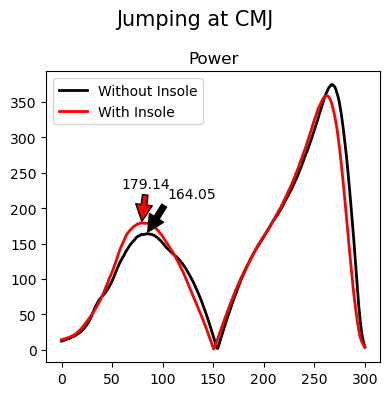

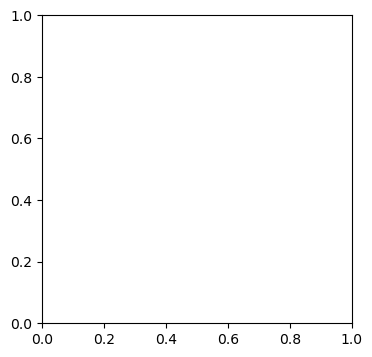

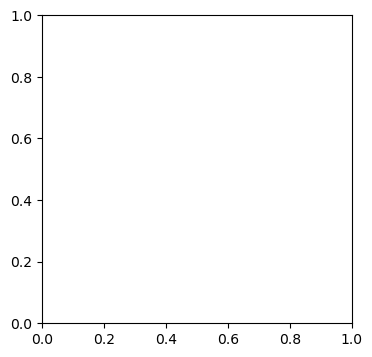

In [73]:
for i,c in enumerate(['Power','Impulse','Force']):
    f_cmj = pd.DataFrame()
    s_cmj = pd.DataFrame()
    for order in ['1차', '2차']:
        for trial in CMJJUMP[order]:        
            df = pd.Series(CMJJUMP[order][trial][c], name=trial)

            if order == '1차':
                f_cmj = pd.concat([f_cmj, df], axis=1)
            if order == '2차':
                s_cmj = pd.concat([s_cmj, df], axis=1)

    Y0 = f_cmj.values.T
    Y1 = s_cmj.values.T
    x = np.linspace(0,300,300)
    fig, ax = plt.subplots(figsize=(4,4))
    if c == 'Power':
        plt.plot(x, Y0[0,:],c = 'k',lw=2,label='Without Insole')
        plt.plot(x, Y1[0,:], c='r', lw=2, label='With Insole')
        plt.legend()
        plt.title(c)
    
        ymax = max(Y0[0,:][:150])
        xpos = np.argmax(Y0[0,:][:150])
        xmax = x[xpos]

        # 최대값에 화살표와 주석을 추가합니다.
        plt.annotate('{:.2f}'.format(ymax), xy=(xmax, ymax), xytext=(xmax+20, ymax+50),
                    arrowprops=dict(facecolor='black', shrink=0.05))
        
        ymax = max(Y1[0,:][:150])
        xpos = np.argmax(Y1[0,:][:150])
        xmax = x[xpos]

        # 최대값에 화살표와 주석을 추가합니다.
        plt.annotate('{:.2f}'.format(ymax), xy=(xmax, ymax), xytext=(xmax-20, ymax+50),
                    arrowprops=dict(facecolor='red', shrink=0.05))
        plt.suptitle('Jumping at CMJ',fontsize=15)
        plt.tight_layout()

In [18]:
Y1[[0],:].shape

(1, 300)

In [36]:
100 * 4/300, 100 * 32/300

(1.3333333333333333, 10.666666666666666)

In [38]:
100*69/300, 100*101/300

(23.0, 33.666666666666664)

In [39]:
100*181/300, 100*222/300

(60.333333333333336, 74.0)

### CMJ Landing

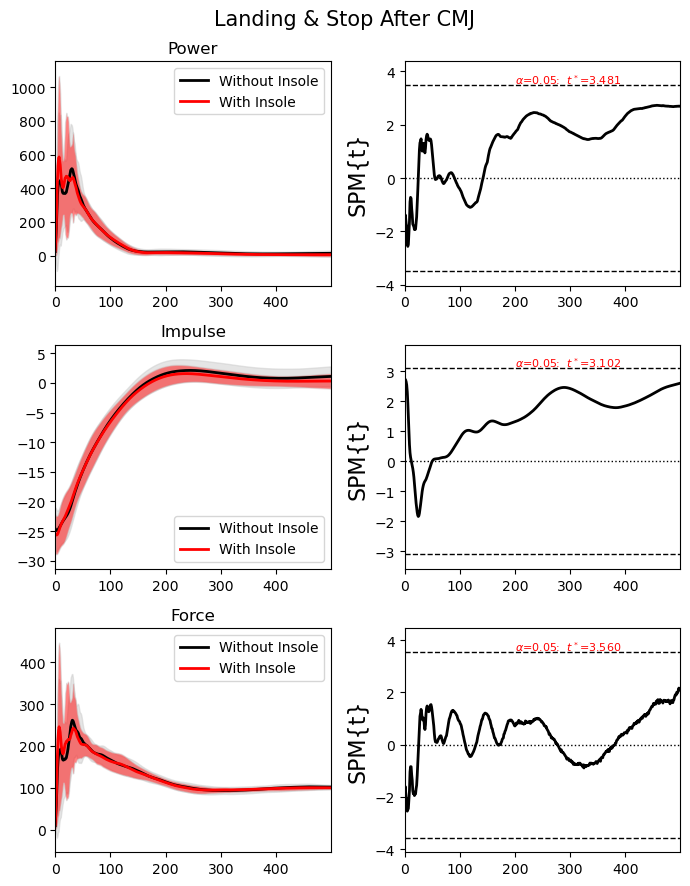

In [6]:
fig, ax = plt.subplots(3,2, figsize=(7,9))
for i,c in enumerate(['Power','Impulse','Force']):
    f_cmj = pd.DataFrame()
    s_cmj = pd.DataFrame()
    for order in ['1차', '2차']:
        for trial in CMJLAND[order]:
        
            df = pd.Series(CMJLAND[order][trial][c], name=trial)
            if order == '1차':
                f_cmj = pd.concat([f_cmj, df], axis=1)
            if order == '2차':
                s_cmj = pd.concat([s_cmj, df], axis=1)


    Y0 = f_cmj.values.T
    Y1 = s_cmj.values.T
    
    # t  = spm1d.stats.ttest2(Y0, Y1, equal_var=False)
    # ti = t.inference(alpha=0.05, two_tailed=True, interp=True)
    
    spm1d.plot.plot_mean_sd(Y0, ax=ax[i,0],label='Without Insole',lw=2)
    spm1d.plot.plot_mean_sd(Y1, linecolor='r', facecolor='r',lw=2, ax=ax[i,0], label='With Insole')
    t  = spm1d.stats.ttest_paired(Y0, Y1)
    ti = t.inference(alpha=0.05, two_tailed=True)
    ti.plot(ax=ax[i,1])
    ti.plot_threshold_label(fontsize=8, ax=ax[i,1])
    ti.plot_p_values(size=10, offsets=[(0,0.3)], ax=ax[i,1])
    ax[i,0].set_title(c)
    ax[i,0].legend()

plt.suptitle('Landing & Stop After CMJ', fontsize=15)
plt.tight_layout()
plt.savefig('Landing & Stop After CMJ.png',dpi=300)

### Land Stop

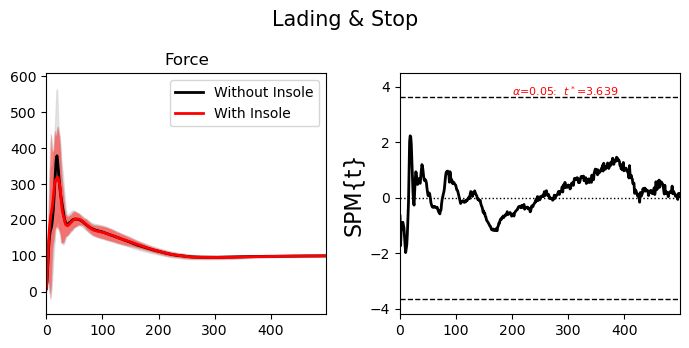

In [7]:
fig, ax = plt.subplots(1,2, figsize=(7,3.5))
for i, c in enumerate(['Force']):
    f_land = pd.DataFrame()
    s_land = pd.DataFrame()
    for order in ['1차', '2차']:
        for trial in LAND[order]:
        
            df = pd.Series(LAND[order][trial][c], name=trial)
            if order == '1차':
                f_land = pd.concat([f_land, df], axis=1)
            if order == '2차':
                s_land = pd.concat([s_land, df], axis=1)


    Y0 = f_land.values.T
    Y1 = s_land.values.T
    
    # t  = spm1d.stats.ttest2(Y0, Y1, equal_var=True)
    # ti = t.inference(alpha=0.05, two_tailed=True, interp=True)
    
    spm1d.plot.plot_mean_sd(Y0, ax=ax[0],lw=2,label='Without Insole')
    spm1d.plot.plot_mean_sd(Y1, linecolor='r', lw=2,facecolor='r', ax=ax[0], label='With Insole')
    t  = spm1d.stats.ttest_paired(Y0, Y1)
    ti = t.inference(alpha=0.05, two_tailed=True)
    ti.plot(ax=ax[1])
    ti.plot_threshold_label(fontsize=8, ax=ax[1])
    ti.plot_p_values(size=10, offsets=[(0,0.3)], ax=ax[1])
    ax[0].set_title(c)
    ax[0].legend()
    
plt.suptitle('Lading & Stop', fontsize=15)
plt.tight_layout()
plt.savefig('Landing & Stop.png', dpi=300)

# Paired T-test [Peak]

### CMJ landing

In [16]:
data = {
    'Power' : '',
    'Impulse' : '',
    'Force' : ''
}
for c in CMJLAND_PEAK['1차'].columns:
    pre = CMJLAND_PEAK['1차'][[c]]
    post = CMJLAND_PEAK['2차'][[c]]
    df = pd.concat([pre,post],axis=1)
    df.columns = ['pre','post']
    melted_df = df.melt(var_name="Condition", value_name="values")
    for i in range(len(melted_df['Condition'])):
        if melted_df['Condition'][i] == 'pre':
            melted_df['Condition'][i] = 'Without Insole'
        elif melted_df['Condition'][i] == 'post':
            melted_df['Condition'][i] = 'With Insole'
    data[c] = melted_df
    display(pg.normality(pre))
    display(pg.normality(post))
    display(pg.homoscedasticity(df))

,W,pval,normal
Power,0.929255,0.006402,False


,W,pval,normal
Power,0.922951,0.003783,False


,W,pval,equal_var
levene,1.301792,0.256785,True


,W,pval,normal
Impulse,0.932874,0.008716,False


,W,pval,normal
Impulse,0.95757,0.080523,True


,W,pval,equal_var
levene,2.906629,0.091519,True


,W,pval,normal
Force,0.972906,0.327327,True


,W,pval,normal
Force,0.902068,0.000734,False


,W,pval,equal_var
levene,1.912087,0.170008,True


In [17]:
for c in CMJLAND_PEAK['1차'].columns:
    pre = CMJLAND_PEAK['1차'][c]
    post = CMJLAND_PEAK['2차'][c]
    print(c)
    display(pg.ttest(pre,post, paired=True).round(3))



Power


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.752,47,two-sided,0.086,"[-209.11, 14.42]",0.256,0.645,0.412


Impulse


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.0,47,two-sided,0.004,"[0.29, 1.47]",0.494,7.911,0.918


Force


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.374,47,two-sided,0.176,"[-70.33, 13.25]",0.225,0.378,0.334


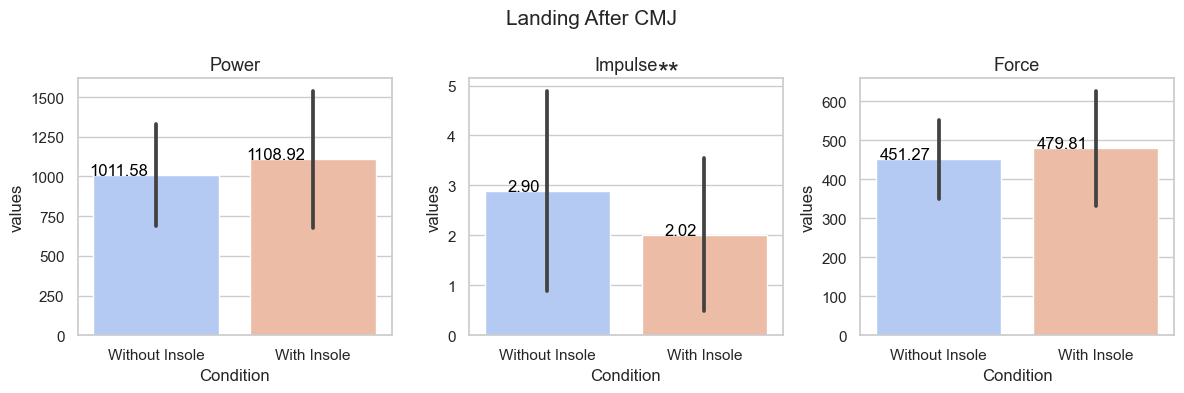

In [18]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(1,3, figsize=(12,4))
for i, c in enumerate(filt_cols):
    means = data[c].groupby("Condition")['values'].mean()
    means = pd.DataFrame(means)
    sns.barplot(data=data[c],x='Condition',y='values', ci='sd',ax=ax[i],palette="coolwarm")
    for index, row in means.iterrows():
        if index == 'Without Insole':
            index = 0
        elif index == 'With Insole':
            index = 1
        ax[i].text(index-0.05,row.values[0], f"{row.values[0]:.2f}", color = 'black', ha='right')
    # Set title and labels
    ax[i].set_title(c, fontsize=13)
    # ax[i].set_xlabel('Condition', fontsize=14)

    # ax[i].set_ylabel('', fontsize=14)
ax[1].text(x=0.7, y= 5.1, s = '**',fontsize=20)
plt.suptitle('Landing After CMJ',fontsize=15)
plt.tight_layout()
plt.savefig('Landing After CMJ(bar).png',dpi=300)

### CMJ jumping

In [19]:
data = {
    'Power' : '',
    'Impulse' : '',
    'Force' : ''
}
for c in CMJJUMP_PEAK['1차'].columns:
    pre = CMJJUMP_PEAK['1차'][[c]]
    post = CMJJUMP_PEAK['2차'][[c]]
    df = pd.concat([pre,post],axis=1)
    df.columns = ['pre','post']
    melted_df = df.melt(var_name="Condition", value_name="values")
    for i in range(len(melted_df['Condition'])):
        if melted_df['Condition'][i] == 'pre':
            melted_df['Condition'][i] = 'Without Insole'
        elif melted_df['Condition'][i] == 'post':
            melted_df['Condition'][i] = 'With Insole'
    data[c] = melted_df
    display(pg.normality(pre))
    display(pg.normality(post))
    display(pg.homoscedasticity(df))

,W,pval,normal
Power,0.905693,0.000965,False


,W,pval,normal
Power,0.942119,0.019592,False


,W,pval,equal_var
levene,0.231427,0.631586,True


,W,pval,normal
Impulse,0.93845,0.014154,False


,W,pval,normal
Impulse,0.950773,0.042926,False


,W,pval,equal_var
levene,0.147928,0.701392,True


,W,pval,normal
Force,0.898571,0.000566,False


,W,pval,normal
Force,0.890187,0.000308,False


,W,pval,equal_var
levene,0.913496,0.34164,True


In [20]:
for c in CMJJUMP_PEAK['1차'].columns:
    pre = CMJJUMP_PEAK['1차'][c]
    post = CMJJUMP_PEAK['2차'][c]
    print(c)
    display(pg.ttest(pre,post, paired=True).round(3))

Power


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.789,47,two-sided,0.434,"[-5.81, 13.31]",0.044,0.21,0.06


Impulse


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.769,47,two-sided,0.446,"[-0.22, 0.5]",0.039,0.207,0.058


Force


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.742,47,two-sided,0.462,"[-9.23, 4.26]",0.089,0.203,0.093


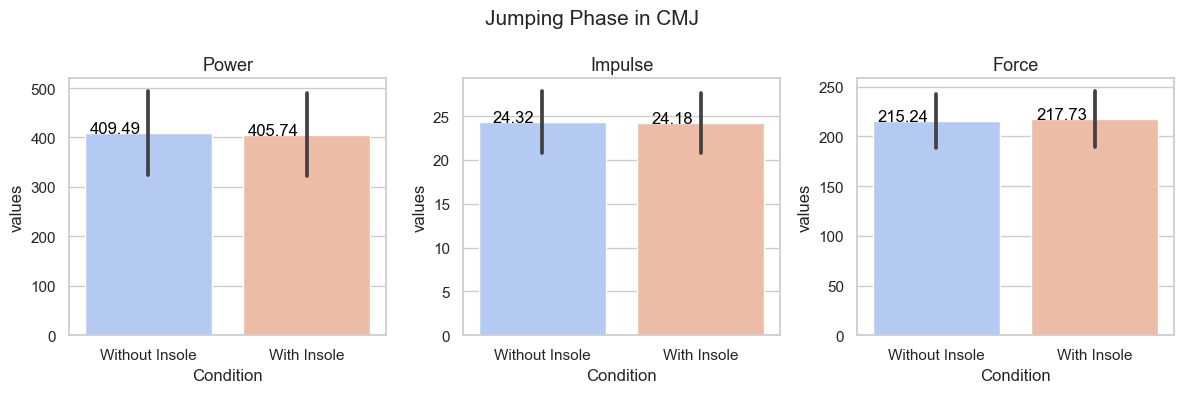

In [21]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
for i, c in enumerate(filt_cols):
    means = data[c].groupby("Condition")['values'].mean()
    means = pd.DataFrame(means)
    sns.barplot(data=data[c],x='Condition',y='values', ci='sd',ax=ax[i],palette="coolwarm")
    for index, row in means.iterrows():
        if index == 'Without Insole':
            index = 0
        elif index == 'With Insole':
            index = 1
        ax[i].text(index-0.05,row.values[0], f"{row.values[0]:.2f}", color = 'black', ha='right')
    # Set title and labels
    ax[i].set_title(c, fontsize=13)
    # ax[i].set_xlabel('Condition', fontsize=14)

    # ax[i].set_ylabel('', fontsize=14)

plt.suptitle('Jumping Phase in CMJ',fontsize=15)
plt.tight_layout()
plt.savefig('Jumping Phase in CMJ (bar).png',dpi=300)

### Landing & Stop

In [22]:
pre = pd.DataFrame(LAND_PEAK['1차'], columns = ['Force'])
post = pd.DataFrame(LAND_PEAK['2차'], columns = ['Force'])
df = pd.concat([pre,post],axis=1)
df.columns = ['pre','post']
melted_df = df.melt(var_name="Condition", value_name="values")
for i in range(len(melted_df['Condition'])):
    if melted_df['Condition'][i] == 'pre':
        melted_df['Condition'][i] = 'Without Insole'
    elif melted_df['Condition'][i] == 'post':
        melted_df['Condition'][i] = 'With Insole'
display(pg.normality(pre))
display(pg.normality(post))
display(pg.homoscedasticity(df))
display(pg.ttest(pre['Force'],post['Force'], paired=True).round(3))

,W,pval,normal
Force,0.97531,0.401452,True


,W,pval,normal
Force,0.961932,0.120842,True


,W,pval,equal_var
levene,1.909403,0.170305,True


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.047,47,two-sided,0.963,"[-38.57, 40.39]",0.007,0.157,0.05


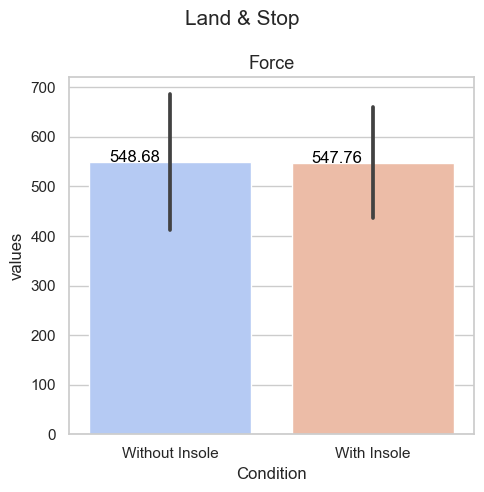

In [23]:
fig, ax = plt.subplots(figsize=(5,5))

means = melted_df.groupby("Condition")['values'].mean()
means = pd.DataFrame(means)
sns.barplot(data=melted_df,x='Condition',y='values', ci='sd',palette="coolwarm")
for index, row in means.iterrows():
    if index == 'Without Insole':
        index = 0
    elif index == 'With Insole':
        index = 1
    ax.text(index-0.05,row.values[0], f"{row.values[0]:.2f}", color = 'black', ha='right')

ax.set_title(c, fontsize=13)

plt.suptitle('Land & Stop',fontsize=15)
plt.tight_layout()
plt.savefig('Land & Stop (bar).png', dpi =300)

In [53]:
pre = pd.DataFrame(JUMPTIME['1차'], columns = ['Force'])
post = pd.DataFrame(JUMPTIME['2차'], columns = ['Force'])
df = pd.concat([pre,post],axis=1)
df.columns = ['pre','post']
melted_df = df.melt(var_name="Condition", value_name="values")
for i in range(len(melted_df['Condition'])):
    if melted_df['Condition'][i] == 'pre':
        melted_df['Condition'][i] = 'Without Insole'
    elif melted_df['Condition'][i] == 'post':
        melted_df['Condition'][i] = 'With Insole'
display(pg.normality(pre))
display(pg.normality(post))
display(pg.homoscedasticity(df))
display(pg.ttest(pre['Force'],post['Force'], paired=True).round(3))

,W,pval,normal
Force,0.918773,0.002692,False


,W,pval,normal
Force,0.944885,0.025113,False


,W,pval,equal_var
levene,0.032787,0.856701,True


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.649,47,two-sided,0.106,"[-0.02, 0.0]",0.108,0.551,0.114


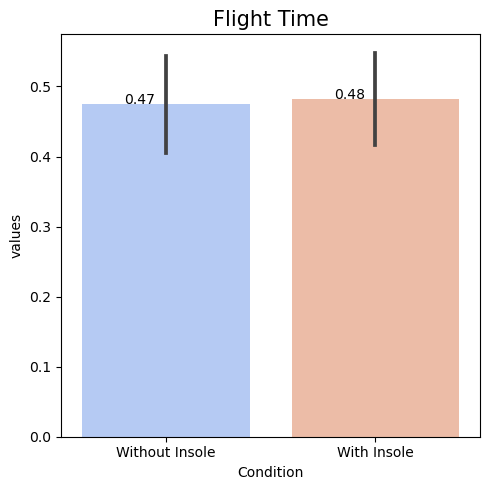

In [59]:
fig, ax = plt.subplots(figsize=(5,5))

means = melted_df.groupby("Condition")['values'].mean()
means = pd.DataFrame(means)
sns.barplot(data=melted_df,x='Condition',y='values', ci='sd',palette="coolwarm")
for index, row in means.iterrows():
    if index == 'Without Insole':
        index = 0
    elif index == 'With Insole':
        index = 1
    ax.text(index-0.05,row.values[0], f"{row.values[0]:.2f}", color = 'black', ha='right')

ax.set_title('Flight Time', fontsize=15)

# plt.suptitle('Flight Time',fontsize=15)
plt.tight_layout()
plt.savefig('Flight (bar).png', dpi =300)

# PCA

In [353]:
land = pd.concat([f_land, s_land], axis=1)
cmj = pd.concat([f_cmj, s_cmj], axis=1)

In [363]:
l_f_pca = PCA(n_components=5)
l_s_pca = PCA(n_components=5)


land_f_pca = l_f_pca.fit_transform(f_land)
land_s_pca = l_s_pca.fit_transform(s_land)

print(sum(l_f_pca.explained_variance_ratio_[:2]))
print(sum(l_s_pca.explained_variance_ratio_[:2]))

0.8904205308895434
0.9034501934361233


In [364]:
land_f_pca = pd.DataFrame(land_f_pca[:,:2], columns = ['PC1','PC2'])
land_s_pca = pd.DataFrame(land_s_pca[:,:2], columns = ['PC1','PC2'])

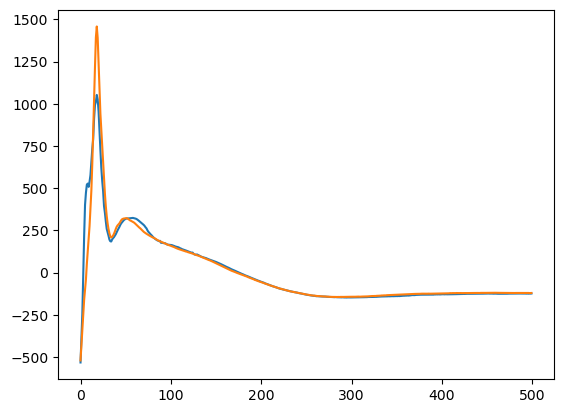

In [378]:
plt.plot(land_s_pca['PC1'])
plt.plot(land_f_pca['PC1'])

In [350]:
land_pca = l_pca.fit_transform(land)
cmj_pca = c_pca.fit_transform(cmj)

In [352]:
l_pca.explained_variance_ratio_, c_pca.explained_variance_ratio_

(array([0.69701018, 0.18339005, 0.04992212, 0.0237531 , 0.01421182]),
 array([0.61875515, 0.21807863, 0.05667846, 0.03701227, 0.01978808]))

In [308]:
land_pca = pd.DataFrame(land_pca[:,:3], columns = ['PC1','PC2','PC3'])
cmj_pca = pd.DataFrame(cmj_pca[:,:3], columns = ['PC1','PC2','PC3'])